In [1]:
%cd ..

/mnt/cup/labs/hasson/zaid/fmri-convs


In [2]:
from glob import glob

import pickle
import numpy as np
from voxelwise_tutorials.delayer import Delayer
import matplotlib.pyplot as plt
from nilearn.glm.first_level import glover_hrf
from himalaya.viz import plot_alphas_diagnostic
from nilearn.plotting import plot_glass_brain

import pandas as pd
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from util.path import Path
from constants import RUNS, NRUNS, TR

In [3]:
sub = 1
conv = str(sub + 100 if sub < 100 else sub)
modelname = "gpt2"

In [4]:
eventpath = Path(
    root="stimuli",
    conv=conv,
    datatype="audio",
    run=1,
    suffix="events",
    ext=".csv",
)

dfs = []
for run in RUNS:
    eventpath = eventpath.update(run=run)
    dft = pd.read_csv(eventpath, index_col=0)
    dfs.append(dft)
dft = pd.concat(dfs)

# keep only condition and when trials start and end
# we have to take line after `trial_intro` because there is the prompt screen
ids = sorted((dft[dft.role == 'trial_intro'].index + 1).tolist() + (dft[dft.role == 'trial_end'].index).tolist())
dft2 = dft.iloc[ids]
dft2 = dft2[dft2.condition == 'G']

dft2

,run,trial,item,condition,role,time.time,run.time,comm.time,audio_position
index,,,,,,,,,
2,1,1.0,1.0,G,listener,1.578505e+09,21.075961,0.000015,0
10,1,1.0,1.0,G,trial_end,1.578505e+09,201.099154,180.023208,5713920
21,1,3.0,3.0,G,speaker,1.578506e+09,423.196448,0.000013,11431936
27,1,3.0,3.0,G,trial_end,1.578506e+09,603.293298,180.096864,17162240
42,2,2.0,5.0,G,listener,1.578507e+09,222.132260,0.000013,28643328
48,2,2.0,5.0,G,trial_end,1.578507e+09,402.162079,180.029833,34373632
54,2,4.0,7.0,G,listener,1.578507e+09,624.260458,0.000013,40124416
59,2,4.0,7.0,G,trial_end,1.578507e+09,804.324111,180.063667,45862912
68,3,2.0,10.0,G,speaker,1.578508e+09,222.124817,0.000015,51605504


In [6]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=1000, resolution_mm=2)

In [7]:
import warnings

boldpath = Path(
    root="data/derivatives/fmriprep",
    sub=f"{sub:03d}",
    ses="1",
    datatype="func",
    task="Conv",
    run=1,
    space="MNI152NLin2009cAsym",
    desc="preproc",
    suffix="bold",
    ext=".nii.gz",
)

confounds = ['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
'a_comp_cor_04','trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
# 'cosine00']

sub_maskers = []
bold_trials = []
for run in RUNS:
    boldpath = boldpath.update(run=run)
    print(run, boldpath.fpath)

    confoundpath = boldpath.copy()
    del confoundpath['space']
    confoundpath.update(desc='confounds', suffix='timeseries', ext='.tsv')
    confound_df = pd.read_csv(confoundpath, sep='\t', usecols=confounds)

    # Resample
    label_masker = NiftiLabelsMasker(labels_img=atlas.maps)
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        fmri_matrix = label_masker.fit_transform(boldpath, confounds=confound_df.to_numpy())
    # print(fmri_matrix.shape)  # 544, 400
    sub_maskers.append(label_masker)

    trial_times = (dft2[dft2.run == run]['run.time'] / TR).round().astype(int).tolist()
    # print(trial_times)
    t1onset, t1offset = trial_times[0:2]
    t2onset, t2offset = trial_times[2:4]

    bold_trials.append(fmri_matrix[t1onset:t1offset])
    bold_trials.append(fmri_matrix[t2onset:t2offset])
    break

print([x.shape for x in bold_trials])
Y_bold = np.vstack(bold_trials)
Y_bold.shape

1 data/derivatives/fmriprep/sub-001/ses-1/func/sub-001_ses-1_task-Conv_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[(120, 1000), (120, 1000)]


(240, 1000)

In [10]:
# Load embeddings for all runs and trials (as available)
embpath = Path(
    root="stimuli",
    conv="101",
    datatype="transcript",
    suffix="transcript",
    ext=".csv",
)
files = sorted(glob(embpath.starstr(['conv', 'datatype'])))
assert len(files)
dfs = []
for fname in files:
    # df = pd.read_pickle(fname)
    df = pd.read_csv(fname, index_col=0)

    # NOTE - temporary fix to put correct speaker labels
    first = Path.frompath(fname)['first']
    convid = int(conv)
    turns = df.turn.unique()
    starting = [convid - 100, convid] if first == 'A' else [convid, convid - 100]
    speakers = np.tile(starting, len(turns))
    turn2spk = {turn: spk for turn, spk in zip(turns, speakers)}
    df['speaker'] = df.groupby('turn').turn.transform(lambda x: turn2spk[x.iloc[0]])

    dfs.append(df)
dfemb = pd.concat(dfs).reset_index(drop=True)

In [21]:
dfemb.groupby(['trial', 'speaker', 'turn']).first()

run  utterance  sentence_id     token token_norm   onset   
trial speaker turn                                                             
1     1       1       1          0            0        Hi         hi    4.00  \
              3       1          2            0        Um         um  119.28   
      101     2       1          1            0        I           i   61.62   
3     1       2       1          1            0     That        that   38.00   
              4       1          3            0        Oh         oh  100.39   
              6       1          5            0        Oh         oh  147.00   
      101     1       1          0            0        Uh         uh    2.41   
              3       1          2            0     Yeah        yeah   77.00   
              5       1          4            0     Then        then  127.00   
6     1       1       2          0            0        Oh         oh    2.06   
              3       2          2            0     That        that   84.00   
              5       2          4            0        Oh         oh  140.14   
      101     2       2          1            0      Yeah       yeah   45.00   
              4       2          3            0   That's      that's  122.07   
              6       2          5            0      Yeah       yeah  169.40   
8     1       1       2          0            0        Um         um    2.00   
              3       2          2            0        Oh         oh  101.20   
              5       2          4            0        Oh         oh  168.00   
      101     2       2          1            0        Oh         oh   58.39   
              4       2          3            0    Cause       cause  135.00   
10    1       2       3          1            0        Um         um   56.00   
              4       3          3            0        Oh         oh  132.28   
      101     1       3          0            0        Um         um    3.00   
              3       3          2            0      Yeah       yeah  117.00   
              5       3          4            0      All         all  145.23   
11    1       2       3          1            0  Honestly   honestly   45.00   
              4       3          3            0        Oh         oh  132.00   
      101     1       3          0            0     What        what    2.41   
              3       3          2            0      Yeah       yeah   89.00   
              5       3          4            0    Agreed     agreed  161.44   
13    1       2       4          1            0   That's      that's   57.16   
              4       4          4            0       Oh          oh  154.00   
      101     1       4          0            0        Um         um    2.15   
              3       4          2            0   That's      that's  107.00   
16    1       2       4          1            0        So         so   53.00   
              4       4          3            0  Honestly   honestly  134.00   
      101     1       4          0            0        Um         um    3.00   
              3       4          2            0        I           i   89.00   
              5       4          4            0     Boba        boba  163.39   
18    1       1       5          0            0        Oh         oh    2.29   
              3       5          2            0        Oh         oh   82.14   
      101     2       5          1            0        Um         um   21.00   
              4       5          3            0      Yeah       yeah  128.27   
19    1       1       5          0            0        Um         um    2.00   
              3       5          3            0        No         no  164.38   
      101     2       5          1            0      Yeah       yeah   63.64   

                    offset  
trial speaker turn          
1     1       1       4.34  
              3     119.59  
      101     2      61.65  
3     1       2      38.22  
     

In [14]:
uttdf = dfemb.groupby(['trial', 'speaker', 'sentence_id']).token.apply(lambda x: ' '.join(x))
uttdf

trial  speaker  sentence_id
1      1        0              Hi Um so sorry  about  that first  of  all and...
                1              Um so  given  the  choice  of  anyone  in  the...
                2              You  probably  don't  know  who  he  is  but  ...
                3              I  think  he's  just  a  really  admirable  pe...
                4              Um so yeah Um also  in  terms  of  writers um ...
                                                     ...                        
19     101      5              But like I  think  you  wanna  be  mindful  of...
                6              And  even  if  they're like mad  at  you they ...
                7              Um yeah I  guess  it's  like  being  there  fo...
                8              You  know  if  there's  a  social  event like ...
                9              That  type  of  thing  I  think  would  probab...
Name: token, Length: 148, dtype: object

In [22]:
dfemb.groupby(['trial', 'speaker', 'turn']).onset.diff()

0        NaN
1       0.34
2       0.38
3       0.64
4       0.33
        ... 
4953    0.62
4954    0.17
4955    0.28
4956    0.51
4957    0.56
Name: onset, Length: 4958, dtype: float64

In [27]:
from scipy.stats import zscore

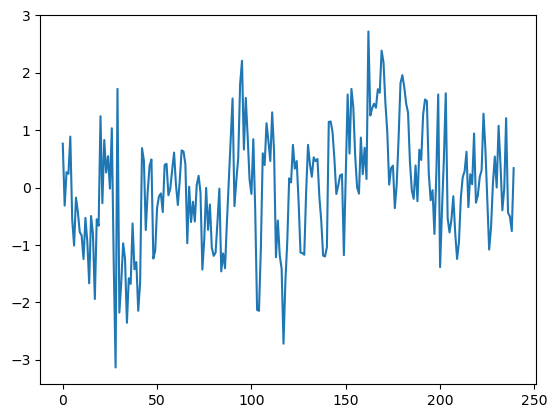

In [33]:
plt.plot(zscore(Y_bold[:, 200]))
plt.savefig('sig.svg')